In [1]:
import sys
sys.path.append('/home/tmerle/DISSECT/Code2D')

In [2]:
from Dissect_allfunctions import *
import skel

In [3]:
#%matplotlib notebook
%matplotlib inline


#import pingouin as pg

In [4]:
def RunDisperse2D(ImDir,ImName,Threshold,MSC=False):
    if MSC:
        os.system('mse '+ImDir+ImName+' -outDir '+ImDir+' -loadMSC '+ImDir+ImName+'.MSC'+' -cut '+Threshold+' -periodicity 0 -upSkl')
    else:
        os.system('mse '+ImDir+ImName+' -outDir '+ImDir+' -cut '+Threshold+' -periodicity 0 -upSkl')
                
    os.system('skelconv '+ImDir+ImName+'_c'+Threshold+'.up.NDskl -outDir '+ImDir+' -toFITS')
    os.system('skelconv '+ImDir+ImName+'_c'+Threshold+'.up.NDskl -outDir '+ImDir+' -to NDskl_ascii')
    
    return


In [5]:
ImDir='/home/tmerle/DISSECT/Code2D/Test1/'
ImName1='C1-20171214_sqh-GFP_ap-alpha-cat-RFP_Dapi_WP2h-002-dorsal_AiSc_croped-bin4_red.tif'
ImName2='C2-20171214_sqh-GFP_ap-alpha-cat-RFP_Dapi_WP2h-002-dorsal_AiSc_croped-bin4_green.tif'

In [6]:
import exifread

with open(ImDir+ImName1, 'rb') as f:
    tags = exifread.process_file(f)
print(tags['Image XResolution'])
print(tags['Image YResolution'])


5457589/1000000
5457589/1000000


In [7]:
N_2=2
tif2fits(ImDir+ImName1+'.fits',ImDir+ImName1,stack=True,N=N_2)
tif2fits(ImDir+ImName2+'.fits',ImDir+ImName2,stack=True,N=N_2)

In [8]:
ImName1fits='C1-20171214_sqh-GFP_ap-alpha-cat-RFP_Dapi_WP2h-002-dorsal_AiSc_croped-bin4_red.tif.fits'
ImName2fits='C2-20171214_sqh-GFP_ap-alpha-cat-RFP_Dapi_WP2h-002-dorsal_AiSc_croped-bin4_green.tif.fits'

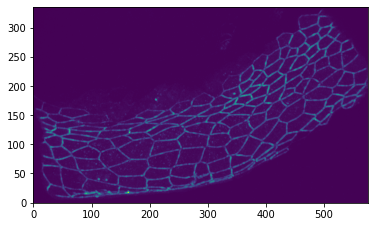

In [9]:
Im1 = fits.getdata(ImDir+ImName1fits)
plt.figure()
plt.imshow(Im1,origin='lower')


reading: 3525 critical points
reading: 3522 filaments
reading: critical points data
critical points done
reading: filaments data


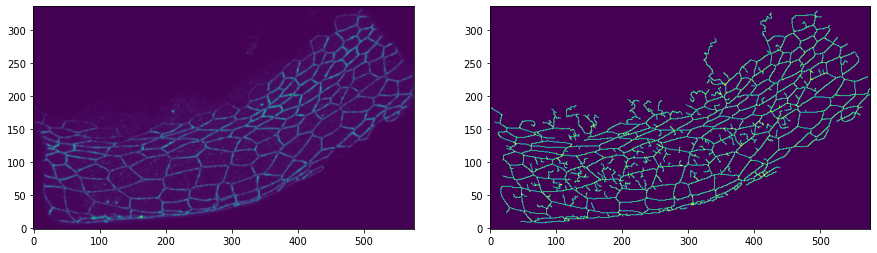

In [10]:
#RUN DISPERSE
Threshold='500'
#RunDisperse2D(ImDir,ImName1,Threshold,MSC=False)
Skel1 = fits.getdata(ImDir+ImName1fits+'_c'+Threshold+'.up.NDskl.fits')
skeleton = skel.Skel(ImDir+ImName1fits+'_c'+Threshold+'.up.NDskl.a.NDskl')

#binarisation du skelet pour vérifier ce qu'on a fait 
#(et constater qu'on a des filaments au milieu des cellules non rattachés d'un côté)
Skel1[np.where(Skel1 != 0)] = 1


fig = plt.figure(figsize=(15,10))
ax1= plt.subplot(1,2,1)
ax1.imshow(Im1,origin='lower')
ax2= plt.subplot(1,2,2,sharex=ax1,sharey=ax1)
ax2.imshow(Skel1,origin='lower')




reading: 3525 critical points
reading: 3522 filaments
reading: critical points data
critical points done
reading: filaments data
[[75.5  9. ]
 [76.5  9. ]
 [77.5  9. ]
 [78.5  9. ]
 [79.5  9. ]
 [80.5  9. ]
 [81.5  9. ]
 [82.5  9. ]
 [83.5  9. ]
 [84.   9.5]
 [84.5 10. ]
 [85.  10. ]]


Text(0.5, 1.0, 'MaskFil')

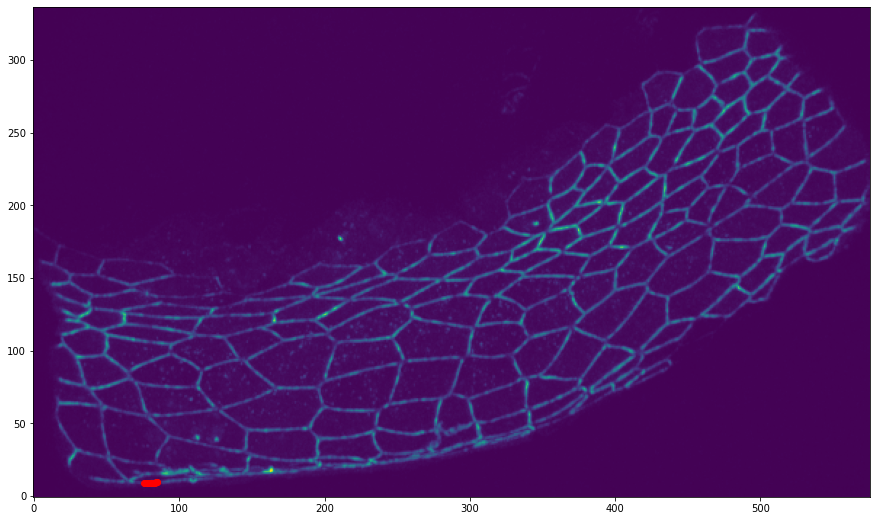

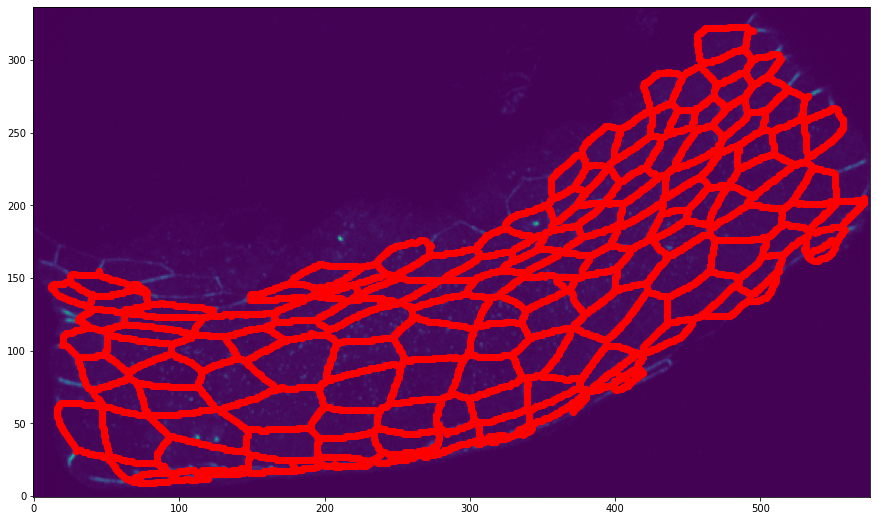

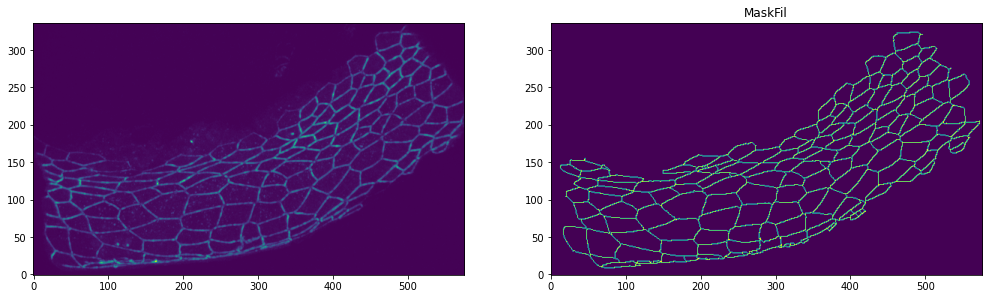

In [11]:
#Nettoyage du squelette. Fonction codée par Sophie en utilisant le module skel de Didier Vibert (astrophysics)

skeleton = skel.Skel(ImDir+ImName1fits+'_c'+Threshold+'.up.NDskl.a.NDskl')
clean_skeleton(skeleton, save=False)

#Tout ce qui suit sert à récupérer une image 

#les coordonnées des extrémités des segments composant le filament 0 :
print(skeleton.fil[0].points)


plt.figure(figsize=(15,15))
plt.imshow(Im1,origin='lower')
plt.scatter(skeleton.fil[0].points[:,0],skeleton.fil[0].points[:,1],color='red')

plt.figure(figsize=(15,15))
plt.imshow(Im1,origin='lower')
for i in range(skeleton.nfil):
    plt.scatter(skeleton.fil[i].points[:,0],skeleton.fil[i].points[:,1],color='red')
    
    

#Masque binaire et propre :  
MaskFil = FilMask_int(skeleton,Im1)

plt.figure(figsize=(17,17))
ax1 = plt.subplot(1,2,1)
ax1.imshow(Im1,origin='lower')
ax2 = plt.subplot(1,2,2,sharex=ax1,sharey=ax1)
ax2.imshow(MaskFil,origin='lower')
ax2.set_title('MaskFil')



Text(0.5, 1.0, 'InvMaskFil')

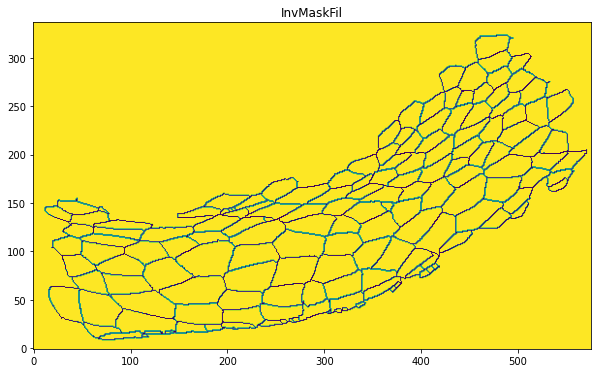

In [12]:
#Inversion de MaskFil pour le watershed
InvMaskFil = np.copy(MaskFil)
InvMaskFil[np.where(MaskFil == 0)] = 1
InvMaskFil[np.where(MaskFil == 1)] = 0

plt.figure(figsize=(10,10))
plt.imshow(InvMaskFil,origin='lower')
plt.title('InvMaskFil')

Text(0.5, 1.0, 'MASKFILTop')

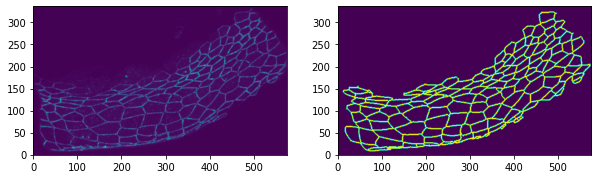

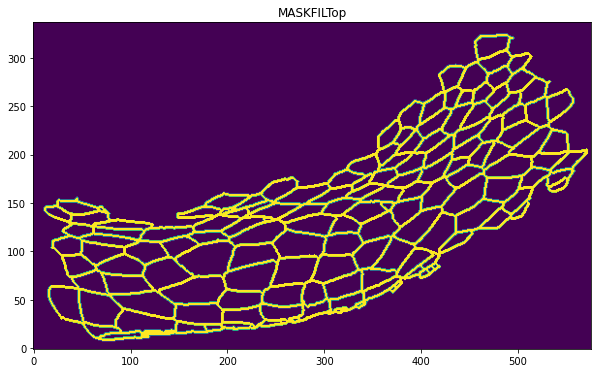

In [13]:
#Elargissement des filaments Top Hat
KernelSize = 1
MASKFILTop = convolve(MaskFil,Tophat2DKernel(KernelSize))
MASKFILTop[np.where(MASKFILTop != 0.)] = 1.


plt.figure(figsize=(10,3))
ax1 = plt.subplot(1,2,1)
ax1.imshow(Im1,origin='lower')
ax1 = plt.subplot(1,2,2,sharex=ax1,sharey=ax1)
ax1.imshow(MASKFILTop,origin='lower')

#Elargissement des filaments Box
#KernelBoxSize =2
#MASKFILBox = convolve(Skel1,Box2DKernel(KernelBoxSize))
#SKEL1Box[np.where(SKEL1Box != 0.)] = 1.

#plt.figure()
#plt.imshow(SKEL1Box)
#plt.title('Skel1Box')

plt.figure(figsize=(10,10))
plt.imshow(MASKFILTop,origin='lower')
plt.title('MASKFILTop')

Text(0.5, 1.0, 'AntiOtsu1')

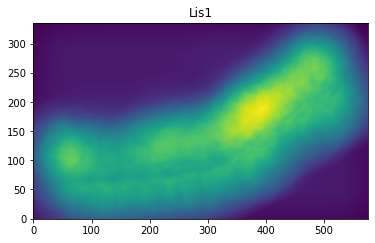

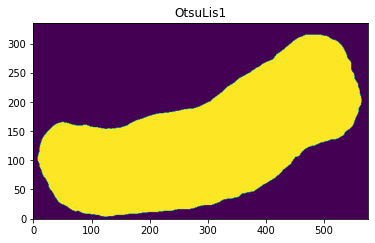

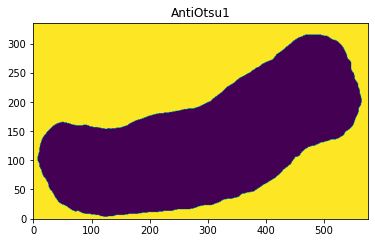

In [14]:
#OTSU FILTER SUR IM1

KernelSize = 50
Lis1 = convolve(Im1,Tophat2DKernel(KernelSize))
plt.figure()

plt.imshow(Lis1,origin='lower')
plt.title('Lis1')

OtsuLis1 = otsufilter(Lis1)
plt.figure()
plt.imshow(OtsuLis1,origin='lower')
plt.title('OtsuLis1')

#AntiOtsu: Fond1 pour normalisation
AntiOtsu1 = ~OtsuLis1
plt.figure()
plt.imshow(AntiOtsu1,origin='lower')
plt.title('AntiOtsu1')


Text(0.5, 1.0, 'MASKFILTOP')

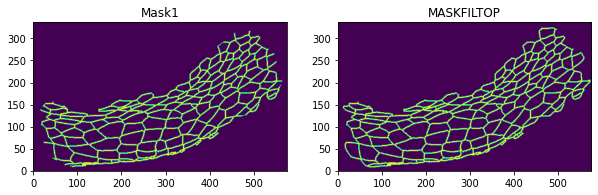

In [15]:
Mask1 = MASKFILTop * OtsuLis1

plt.figure(figsize=(10,6))
ax1 = plt.subplot(1,2,1)
ax1.imshow(Mask1,origin='lower')
ax1.set_title('Mask1')
ax2 = plt.subplot(1,2,2,sharex=ax1,sharey=ax1)
ax2.imshow(MASKFILTop,origin='lower')
ax2.set_title('MASKFILTOP')

Text(0.5, 1.0, 'AntiMask')

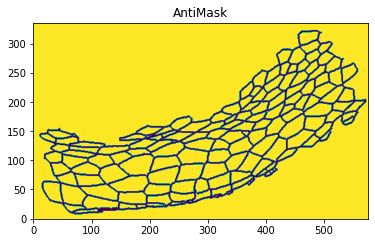

In [16]:
AntiMask = np.copy(MASKFILTop)
AntiMask[np.where(MASKFILTop == 0)] = 1
AntiMask[np.where(MASKFILTop == 1)] = 0

plt.figure()
plt.imshow(AntiMask,origin='lower')
plt.title('AntiMask')

Text(0.5, 1.0, 'Im1WoJunc')

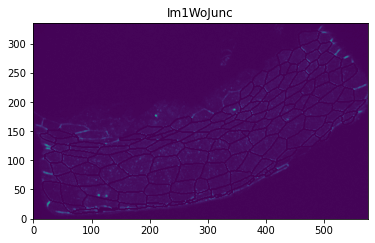

In [17]:
Im1WoJunc = AntiMask * Im1
plt.figure()
plt.imshow(Im1WoJunc,origin='lower')
plt.title('Im1WoJunc')


Text(0.5, 1.0, 'Fond1')

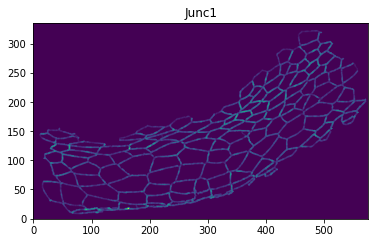

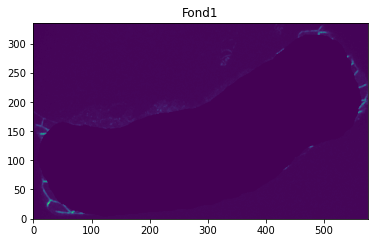

In [18]:
#Junc1
Junc1 = MASKFILTop * Im1
plt.figure()
plt.imshow(Junc1,origin='lower')
plt.title('Junc1')


#Fond 1
Fond1 = AntiOtsu1*Im1
plt.figure()
plt.imshow(Fond1,origin='lower')
plt.title('Fond1')


In [19]:
#Calcul moy1
meanSig1_JuncSig1 = np.mean(Junc1[np.where(Junc1 != 0)]) / np.mean(Fond1[np.where(Fond1 != 0)])
print('mean sig1 normalised=',meanSig1_JuncSig1)

mean = np.mean (Im1[np.where(MASKFILTop == 1)]) / np.mean(Im1[np.where(~OtsuLis1)])
print('mean with 0', mean)

mean sig1 normalised= 16.05678766425387
mean with 0 16.05678766425387


Text(0.5, 1.0, 'OtsuLis2')

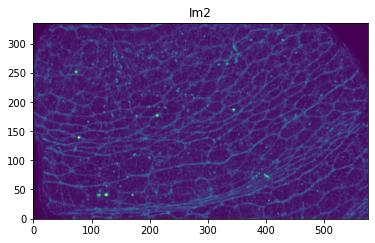

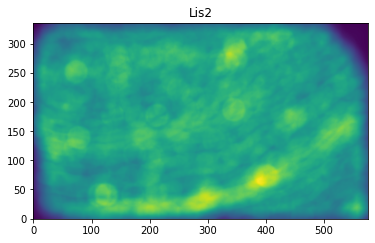

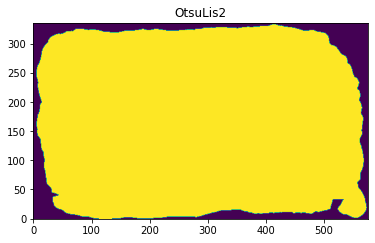

In [20]:
#OTSU FILTER SUR IM2
Im2 = fits.getdata(ImDir+ImName2fits)
plt.figure()
plt.imshow(Im2,origin='lower')
plt.title('Im2')

#Lissage du signal
KernelSize = 20
Lis2 = convolve(Im2,Tophat2DKernel(KernelSize))
plt.figure()
plt.imshow(Lis2,origin='lower')
plt.title('Lis2')

OtsuLis2 = otsufilter(Lis2)
plt.figure()
plt.imshow(OtsuLis2,origin='lower')
plt.title('OtsuLis2')



Text(0.5, 1.0, 'OtsuIm2')

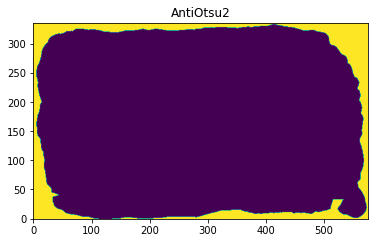

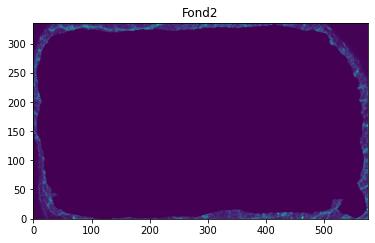

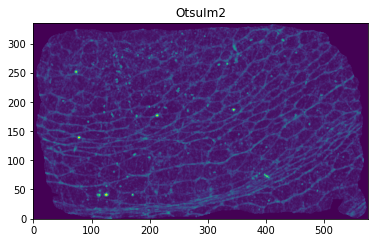

In [21]:

#AntiOtsu: Fond1 pour normalisation
AntiOtsu2 = ~OtsuLis2
plt.figure()
plt.imshow(AntiOtsu2,origin='lower')
plt.title('AntiOtsu2')


Fond2 = AntiOtsu2 * Im2
plt.figure()
plt.imshow(Fond2,origin='lower')
plt.title('Fond2')


OtsuIm2 = OtsuLis2 * Im2
plt.figure()
plt.imshow(OtsuIm2,origin='lower')
plt.title('OtsuIm2')


Text(0.5, 1.0, 'Cell2')

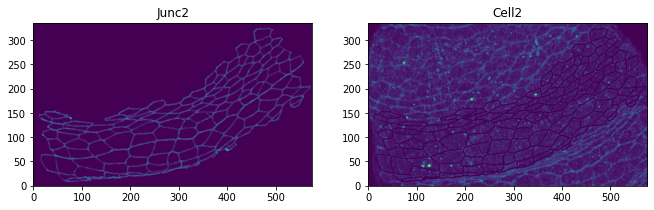

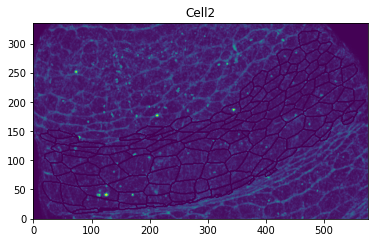

In [22]:
#Apply MASKFILTop to Im2
Junc2 = MASKFILTop * Im2


Cell2 = AntiMask*Im2

plt.figure(figsize=(11,6))
ax1 = plt.subplot(1,2,1)
ax1.imshow(Junc2,origin='lower')
ax1.set_title('Junc2')
ax2 = plt.subplot(1,2,2,sharex=ax1,sharey=ax1)
ax2.imshow(Cell2,origin='lower')
ax2.set_title('Cell2')


plt.figure()
plt.imshow(Cell2,origin='lower')
plt.title('Cell2')

Text(0.5, 1.0, 'Cell22')

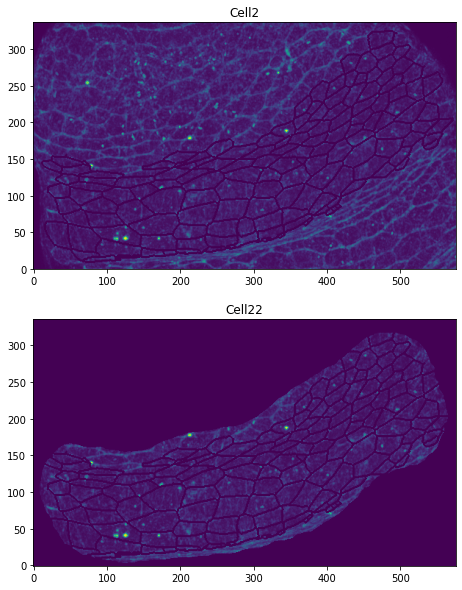

In [23]:
Cell22 = AntiMask * Im2 * OtsuLis1

plt.figure(figsize=(9,10))
ax1 = plt.subplot(2,1,1)
ax1.imshow(Cell2,origin='lower')
ax1.set_title('Cell2')
ax2 = plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
ax2.imshow(Cell22,origin='lower')
ax2.set_title('Cell22')




In [24]:
#Mean filaments Im2 signal where filament Im1
meanSig2_JuncSig1 = np.mean(Im2[np.where(Junc2 != 0)]) / np.mean(Im2[np.where(Fond2 != 0)])
print(meanSig2_JuncSig1)

mean = np.mean (Im2[np.where(MASKFILTop == 1)]) / np.mean(Im2[np.where(~OtsuLis2)])
print(mean)
print('mean sig2 auc jonctions de sig1 normalised=',np.mean(Junc2[np.where(Junc2 != 0)]) / np.mean(Fond2[np.where(Fond2 != 0)]))

2.3169233899590957
2.3169233899590957
mean sig2 auc jonctions de sig1 normalised= 2.3169233899590957


Text(0.5, 1.0, 'Fil2')

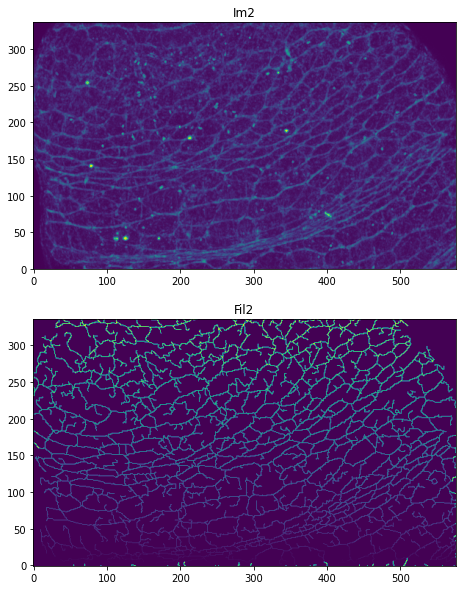

In [25]:
# Disperse sur Im2 pour le fun


# Disperse 
Threshold='1.5e+03'
RunDisperse2D(ImDir,ImName2fits,Threshold,MSC=False)
Fil2 = fits.getdata(ImDir+ImName2fits+'_c'+Threshold+'.up.NDskl.fits')


plt.figure(figsize=(9,10))
ax1 = plt.subplot(2,1,1)
ax1.imshow(Im2,origin='lower')
ax1.set_title('Im2')
ax2 = plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
ax2.imshow(Fil2,origin='lower')
ax2.set_title('Fil2')


Text(0.5, 1.0, 'Sig2')

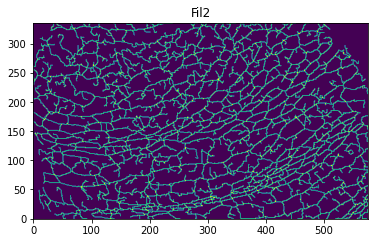

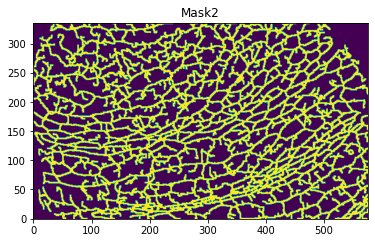

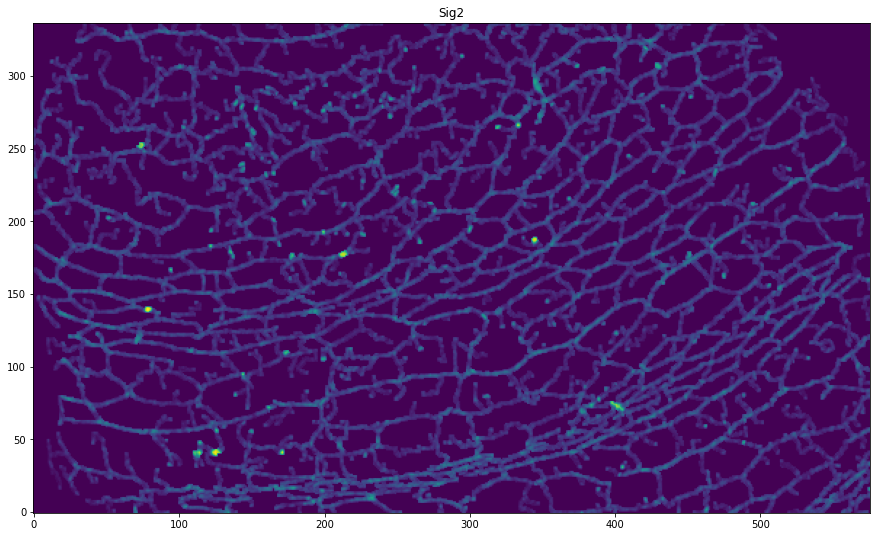

In [26]:
#Binarisation et élargissemment des filaments
Fil2[np.where(Fil2 != 0.)] = 1.
plt.figure()
plt.imshow(Fil2,origin='lower')
plt.title('Fil2')

KernelBoxSize = 2
Mask2 = convolve(Fil2,Box2DKernel(KernelBoxSize))
Mask2[np.where(Mask2 != 0.)] = 1.
plt.figure()
plt.imshow(Mask2,origin='lower')
plt.title('Mask2')



Sig2 = Mask2 * Im2
plt.figure(figsize=(15,15))
plt.imshow(Sig2,origin='lower')
plt.title('Sig2')



In [27]:
print('mean sig2 =',np.mean(Sig2[np.where(Mask2 != 0)]) / np.mean(Im2[np.where(~OtsuLis2)]))

mean sig2 = 2.171659622494289


reading: 8203 critical points
reading: 8079 filaments
reading: critical points data
critical points done
reading: filaments data
reading: 8203 critical points
reading: 8079 filaments
reading: critical points data
critical points done
reading: filaments data


Text(0.5, 1.0, 'MaskFil2')

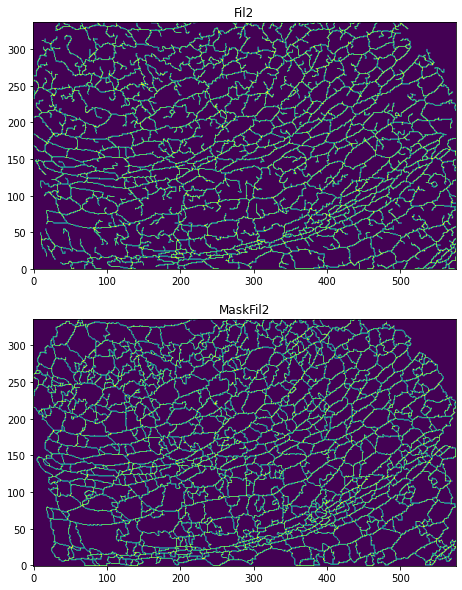

In [28]:
#Nettoyage
Skel2 = fits.getdata(ImDir+ImName2fits+'_c'+Threshold+'.up.NDskl.fits')
skeleton = skel.Skel(ImDir+ImName2fits+'_c'+Threshold+'.up.NDskl.a.NDskl')
skeleton2 = skel.Skel(ImDir+ImName2fits+'_c'+Threshold+'.up.NDskl.a.NDskl')
clean_skeleton(skeleton2, save=False)
#Masque binaire et propre :  
MaskFil2 = FilMask_int(skeleton2,Im2)
plt.figure(figsize=(9,10))
ax1 = plt.subplot(2,1,1)
ax1.imshow(Fil2,origin='lower')
ax1.set_title('Fil2')
ax2 = plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
ax2.imshow(MaskFil2,origin='lower')
ax2.set_title('MaskFil2')

Text(0.5, 1.0, 'TopMaskFil2')

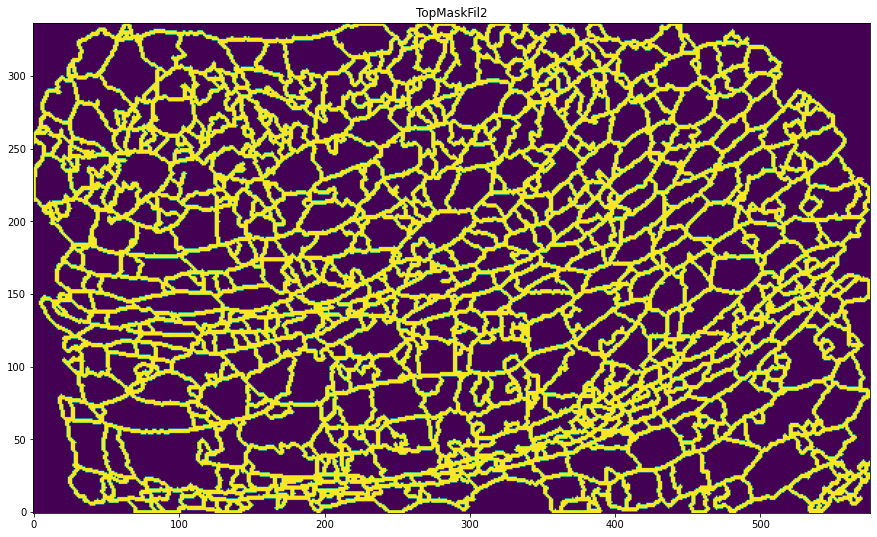

In [29]:
TopMaskFil2 = convolve(MaskFil2,Tophat2DKernel(1))
TopMaskFil2[np.where(TopMaskFil2 != 0.)] = 1.
plt.figure(figsize=(15,15))
plt.imshow(TopMaskFil2,origin='lower')
plt.title('TopMaskFil2')



Text(0.5, 1.0, 'TopMaskFil2')

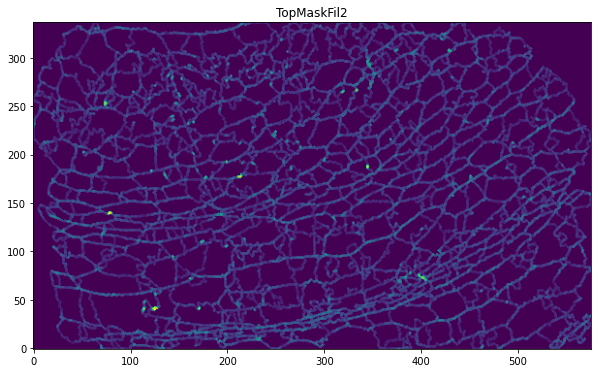

In [31]:
#Global means in filaments for Sig1 and Sig2

normIm1 = NormaliseImage(Im1, 50) 
meanFil1 = np.mean (normIm1[np.where(MASKFILTop == 1)])
print('Sig1: mean in Sig1 filaments ',meanFil1)

normIm2 = NormaliseImage(Im2, 50) 
meanFil2_whereFil1 = np.mean (normIm2[np.where(MASKFILTop == 1)])
print('Sig2: mean in Sig1 filaments',meanFil2_whereFil1)


meanFil2 = np.mean (normIm2[np.where(Mask2 == 1)])
print('Sig2: mean in Sig2 filaments ',meanFil2)

meanFil2_clean = np.mean (normIm2[np.where(TopMaskFil2 == 1)])
print('Sig2: mean in clean Sig2 filaments ',meanFil2_clean)

Sig1: mean in Sig1 filaments  16.056787664253868
Sig2: mean in Sig1 filaments 1.9304583120203314
Sig2: mean in Sig2 filaments  1.8094246824436646
Sig2: mean in clean Sig2 filaments  1.8511588975723592


# Passons à la segmentation


In [32]:
%matplotlib notebook

In [33]:
%matplotlib notebook

In [34]:
%matplotlib notebook

In [35]:
%matplotlib notebook

In [36]:
min_area = 150
seg = segmentation(InvMaskFil,min_area)

<IPython.core.display.Javascript object>


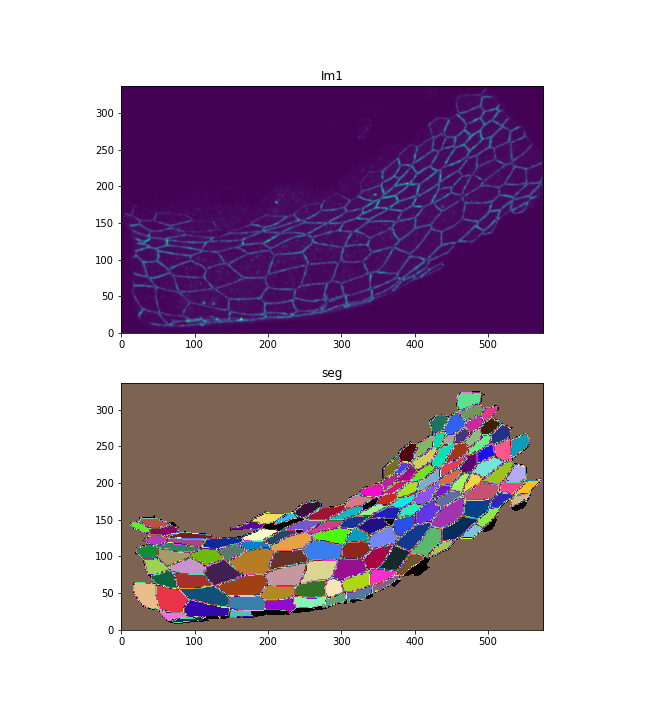

Text(0.5, 1.0, 'seg')

In [37]:
from matplotlib.colors import ListedColormap
rand = np.random.rand(256,3)
rand[0] = 0
cmap_rand = ListedColormap(rand)


plt.figure(figsize=(9,10))
ax1 = plt.subplot(2,1,1)
ax1.imshow(Im1,origin='lower')
ax1.set_title('Im1')
ax2 = plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
ax2.imshow(seg,origin='lower',cmap=cmap_rand)
ax2.set_title('seg')

<IPython.core.display.Javascript object>


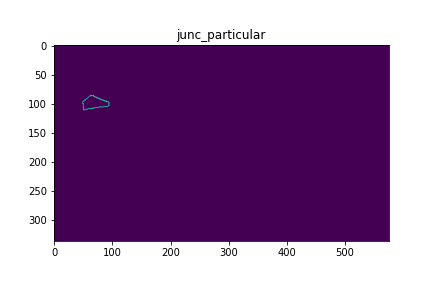

Text(0.5, 1.0, 'junc_particular')

In [38]:
junc_particular = JuncCell(seg, MaskFil, 58)

plt.figure()
plt.imshow(junc_particular)
plt.title('junc_particular')

In [39]:
sigMain1='alphacat'
Dataframe1 = CellStatsMain(seg,MaskFil,normIm1,1,sigMain1)

In [40]:
sigMain2 ="myosin"
Dataframe2 = CellStatsMain(seg,MaskFil,normIm2,1,sigMain2)

In [41]:
pd.set_option('display.max_rows', None)

In [42]:
Dataframe1

CellNbr  meanCell_alphacat  stdCell_alphacat  semCell_alphacat  areaCell  \
0        2.0          10.761564          9.126352          0.646950     200.0   
1        3.0           5.810730          5.317458          0.318348     280.0   
2        6.0           5.144512          6.286712          0.198506    1004.0   
3        8.0           8.484567          8.467836          0.538795     248.0   
4       12.0           2.727216          2.465516          0.071562    1188.0   
5       13.0           4.919377          5.358649          0.227257     557.0   
6       15.0           3.179740          3.689766          0.123960     887.0   
7       16.0           4.134550          4.135682          0.137627     904.0   
8       20.0           4.938568          5.303254          0.228216     541.0   
9       21.0           6.544056          5.839865          0.330089     314.0   
10      22.0           4.528129          4.614891          0.136801    1139.0   
11      25.0           5.367332          5.625927          0.289750     378.0   
12      28.0           3.991245          3.933075          0.146374     723.0   
13      30.0           3.878667          4.136992          0.147656     786.0   
14      31.0           4.399941          4.394638          0.204457     463.0   
15      32.0           3.717669          3.028379          0.081111    1395.0   
16      33.0           3.876918          4.313816          0.162009     710.0   
17      34.0           5.394069          5.339810          0.310370     297.0   
18      35.0           4.003841          3.479846          0.125161     774.0   
19      36.0           4.418771          4.363600          0.187954     540.0   
20      37.0           3.417247          3.249169          0.093562    1207.0   
21      38.0           4.632332          5.453940          0.247396     487.0   
22      39.0           3.741591          3.357662          0.102887    1066.0   
23      42.0           3.180887          2.797980          0.085899    1062.0   
24      43.0           3.251581          2.643775          0.086553     934.0   
25      44.0           5.041712          4.894969          0.230240     453.0   
26      46.0           4.015903          3.502063          0.089649    1527.0   
27      49.0           4.911722          5.105180          0.226729     508.0   
28      50.0           3.624784          3.653219          0.134295     741.0   
29      52.0           3.916833          3.548485          0.127138     780.0   
30      53.0           4.246428          3.491446          0.115487     915.0   
31      54.0           4.195495          4.314075          0.161563     714.0   
32      57.0           4.479178          4.106796          0.157257     683.0   
33      58.0           5.284829          5.807038          0.231542     630.0   
34      59.0           4.353235          4.258916          0.193988     483.0   
35      60.0           4.135385          4.151254          0.122842    1143.0   
36      61.0           5.135818          5.350285          0.254200     444.0   
37      62.0           3.855156          3.622687          0.133898     733.0   
38      63.0           3.879558          4.056846          0.135681     895.0   
39      64.0           4.802132          4.678505          0.282124     276.0   
40      65.0           5.890293          5.950411          0.284322     439.0   
41      66.0           5.008118          4.199574          0.141729     879.0   
42      67.0           5.516763          5.298957          0.282035     354.0   
43      68.0           4.075815          3.748251          0.127963     859.0   
44      69.0           4.402533          3.804629          0.136666     776.0   
45      71.0           4.571401          3.836487          0.163440     552.0   
46      72.0           7.298086          7.398334          0.392111     357.0   
47      73.0           6.709148          6.870828          0.402775     292.0   
48      74.0           5.484814     

In [113]:
Dataframe2


CellNbr  meanCell_myosin  stdCell_myosin  semCell_myosin  areaCell  \
0        2.0         1.857365        0.853132        0.060477     200.0   
1        3.0         1.215508        0.455510        0.027271     280.0   
2        6.0         1.030325        0.646104        0.020401    1004.0   
3        8.0         1.627228        0.894173        0.056895     248.0   
4       12.0         0.831530        0.539629        0.015663    1188.0   
5       13.0         1.113535        0.597578        0.025343     557.0   
6       15.0         0.875611        0.534580        0.017960     887.0   
7       16.0         1.125177        0.937948        0.031213     904.0   
8       20.0         0.981039        0.473038        0.020356     541.0   
9       21.0         1.868709        0.753681        0.042601     314.0   
10      22.0         1.517049        1.777416        0.052689    1139.0   
11      25.0         1.041787        0.569503        0.029331     378.0   
12      28.0         1.329440        0.758237        0.028219     723.0   
13      30.0         1.053170        0.580832        0.020731     786.0   
14      31.0         1.173056        0.569825        0.026511     463.0   
15      32.0         0.982862        0.673147        0.018029    1395.0   
16      33.0         1.123254        0.575789        0.021624     710.0   
17      34.0         1.110599        0.812090        0.047202     297.0   
18      35.0         0.910755        0.511238        0.018388     774.0   
19      36.0         1.014376        0.731509        0.031508     540.0   
20      37.0         1.071333        0.640237        0.018436    1207.0   
21      38.0         1.166750        0.562402        0.025511     487.0   
22      39.0         0.956741        0.633322        0.019407    1066.0   
23      42.0         1.089538        0.530193        0.016277    1062.0   
24      43.0         1.182947        0.764087        0.025015     934.0   
25      44.0         1.281126        0.735585        0.034599     453.0   
26      46.0         0.939407        0.627801        0.016071    1527.0   
27      49.0         1.055990        0.616266        0.027369     508.0   
28      50.0         0.872705        0.537157        0.019746     741.0   
29      52.0         1.070499        0.530877        0.019021     780.0   
30      53.0         1.336776        0.702589        0.023240     915.0   
31      54.0         1.101964        0.746373        0.027952     714.0   
32      57.0         1.007785        0.645097        0.024702     683.0   
33      58.0         1.081226        0.541057        0.021573     630.0   
34      59.0         1.005111        0.819512        0.037328     483.0   
35      60.0         1.126488        0.598968        0.017724    1143.0   
36      61.0         1.228607        0.758820        0.036053     444.0   
37      62.0         0.933201        0.560251        0.020707     733.0   
38      63.0         0.994885        0.529110        0.017696     895.0   
39      64.0         1.296793        0.570704        0.034415     276.0   
40      65.0         1.080452        0.713753        0.034104     439.0   
41      66.0         1.100659        0.614075        0.020724     879.0   
42      67.0         1.418805        1.192699        0.063481     354.0   
43      68.0         1.147886        0.763149        0.026053     859.0   
44      69.0         1.257116        0.669974        0.024066     776.0   
45      71.0         1.153448        0.549174        0.023396     552.0   
46      72.0         1.422253        0.996590        0.052819     357.0   
47      73.0         1.514595        0.981383        0.057530     292.0   
48      74.0         1.025760        0.526230        0.026750     388.0   
49      75.0         1.138315        0.814347        0.029676     754.0   
50      76.0         1.267721        0.762778        0.037950     405.0   
51      77.0         1.199473        0.715441        0.033358     461.0   
52      78.0         1.036406 

In [114]:
import exifread

with open(ImDir+ImName1, 'rb') as f:
    tags = exifread.process_file(f)
print('X px/um =',tags['Image XResolution'])
print('Y px/um =',tags['Image YResolution'])


X px/um = 5457589/1000000
Y px/um = 5457589/1000000


In [115]:
Conv = tags['Image XResolution'].values[0].num/tags['Image XResolution'].values[0].den
print(Conv)

5.457589


In [116]:
Dataframe1['perimeter-um']=Dataframe1['perimeter']/Conv

In [47]:
Dataframe1['area-um2']=Dataframe1['areaCell']/Conv**2

In [48]:
Dataframe1

CellNbr  meanCell_alphacat  stdCell_alphacat  semCell_alphacat  areaCell  \
0        2.0          10.761564          9.126352          0.646950     200.0   
1        3.0           5.810730          5.317458          0.318348     280.0   
2        6.0           5.144512          6.286712          0.198506    1004.0   
3        8.0           8.484567          8.467836          0.538795     248.0   
4       12.0           2.727216          2.465516          0.071562    1188.0   
5       13.0           4.919377          5.358649          0.227257     557.0   
6       15.0           3.179740          3.689766          0.123960     887.0   
7       16.0           4.134550          4.135682          0.137627     904.0   
8       20.0           4.938568          5.303254          0.228216     541.0   
9       21.0           6.544056          5.839865          0.330089     314.0   
10      22.0           4.528129          4.614891          0.136801    1139.0   
11      25.0           5.367332          5.625927          0.289750     378.0   
12      28.0           3.991245          3.933075          0.146374     723.0   
13      30.0           3.878667          4.136992          0.147656     786.0   
14      31.0           4.399941          4.394638          0.204457     463.0   
15      32.0           3.717669          3.028379          0.081111    1395.0   
16      33.0           3.876918          4.313816          0.162009     710.0   
17      34.0           5.394069          5.339810          0.310370     297.0   
18      35.0           4.003841          3.479846          0.125161     774.0   
19      36.0           4.418771          4.363600          0.187954     540.0   
20      37.0           3.417247          3.249169          0.093562    1207.0   
21      38.0           4.632332          5.453940          0.247396     487.0   
22      39.0           3.741591          3.357662          0.102887    1066.0   
23      42.0           3.180887          2.797980          0.085899    1062.0   
24      43.0           3.251581          2.643775          0.086553     934.0   
25      44.0           5.041712          4.894969          0.230240     453.0   
26      46.0           4.015903          3.502063          0.089649    1527.0   
27      49.0           4.911722          5.105180          0.226729     508.0   
28      50.0           3.624784          3.653219          0.134295     741.0   
29      52.0           3.916833          3.548485          0.127138     780.0   
30      53.0           4.246428          3.491446          0.115487     915.0   
31      54.0           4.195495          4.314075          0.161563     714.0   
32      57.0           4.479178          4.106796          0.157257     683.0   
33      58.0           5.284829          5.807038          0.231542     630.0   
34      59.0           4.353235          4.258916          0.193988     483.0   
35      60.0           4.135385          4.151254          0.122842    1143.0   
36      61.0           5.135818          5.350285          0.254200     444.0   
37      62.0           3.855156          3.622687          0.133898     733.0   
38      63.0           3.879558          4.056846          0.135681     895.0   
39      64.0           4.802132          4.678505          0.282124     276.0   
40      65.0           5.890293          5.950411          0.284322     439.0   
41      66.0           5.008118          4.199574          0.141729     879.0   
42      67.0           5.516763          5.298957          0.282035     354.0   
43      68.0           4.075815          3.748251          0.127963     859.0   
44      69.0           4.402533          3.804629          0.136666     776.0   
45      71.0           4.571401          3.836487          0.163440     552.0   
46      72.0           7.298086          7.398334          0.392111     357.0   
47      73.0           6.709148          6.870828          0.402775     292.0   
48      74.0           5.484814     

<IPython.core.display.Javascript object>


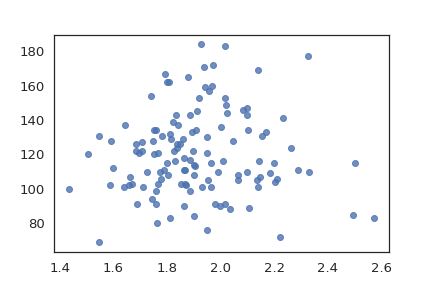

ModuleNotFoundError: No module named 'statsmodels'

In [49]:
plt.figure()
sns.set(style='white', font_scale=1.2)
sns.regplot(y='perimeter', x='meanJunc_myosin', fit_reg=True, data=Dataframe2, robust=True, n_boot=100);
plt.xlabel(' myosin mean in junctions');
plt.ylabel('perimeter');
plt.title('');
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


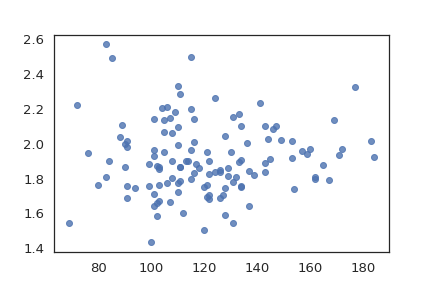

ModuleNotFoundError: No module named 'statsmodels'

In [50]:
plt.figure()
sns.set(style='white', font_scale=1.2)
sns.regplot(x='perimeter', y='meanJunc_myosin', fit_reg=True, data=Dataframe2, robust=True, n_boot=100);
plt.xlabel(' perimeter');
plt.ylabel('myosin mean in junctions');
plt.title('');
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


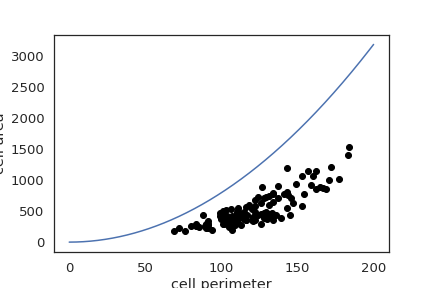

In [51]:
plt.figure()
plt.scatter(Dataframe1['perimeter'],Dataframe1['areaCell'],color='black')
plt.xlabel('cell perimeter')
plt.ylabel('cell area')
xx = np.linspace(0,200,2000)
plt.plot(xx,xx**2/(4*np.pi))

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

<IPython.core.display.Javascript object>


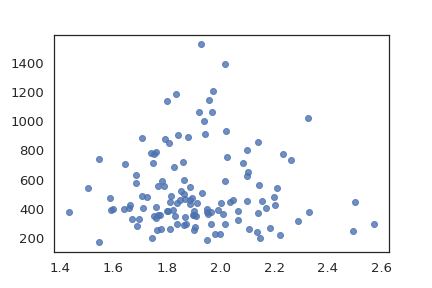

ModuleNotFoundError: No module named 'statsmodels'

In [53]:
plt.figure()
sns.set(style='white', font_scale=1.2)
sns.regplot(y='areaCell', x='meanJunc_myosin', fit_reg=True, data=Dataframe2, robust=True, n_boot=100);
plt.xlabel('meanJunc_myosin');
plt.ylabel('areaCell');
plt.title('');

'''a, b = linear_fit(Dataframe2,ycol='areaCell', xcol='meanJunc_myosin')
xx = np.linspace(Dataframe2['meanJunc_myosin'].min(),Dataframe2['meanJunc_myosin'].max(),100)
plt.plot(xx,a*xx+b,color='red')
'''

fig.tight_layout()
plt.show()

In [54]:
import scipy.stats as st

In [55]:
st.spearmanr(Dataframe1['perimeter'],Dataframe1['areaCell'])

SpearmanrResult(correlation=0.7971332652581716, pvalue=1.006367048635876e-28)

In [56]:
st.pearsonr(Dataframe1['perimeter'],Dataframe1['areaCell'])

(0.8453463611444018, 2.7361033355672017e-35)

In [57]:
sigMain='alphacat'
init = np.zeros((len(np.unique(seg)[2:]),8))
EmbryoStats = pd.DataFrame(data=init,columns=['meanCell_'+sigMain,'stdCell_'+sigMain,'semCell_'+sigMain,'areaCell','meanJunc_'+sigMain,'stdJunc_'+sigMain,'semJunc_'+sigMain,'lenJunc']) 
for i in np.unique(seg)[2:]:
    EmbryoStats['meanCell_'+sigMain][i] = i

# Ellipses

In [58]:
from astropy.modeling import models, fitting
from astropy.modeling.models import Ellipse2D
from astropy.coordinates import Angle
import warnings
%matplotlib inline
# fitting procedure
fit = fitting.SimplexLSQFitter() 
#fit = fitting.LevMarLSQFitter()

In [59]:
def Cell(seg,i):   
    segmentationi = np.zeros_like(seg)
    #for each cell get contour pixels
    segmentationi[np.where(seg == i)] = 1
    return segmentationi

y, x = np.mgrid[0:np.shape(seg)[0], 0:np.shape(seg)[1]] #grille 
init = np.zeros((len(np.unique(seg)[2:]),9))
#Dataframe_geo = pd.DataFrame(data=init,columns=['areaCell','perimeter','x_0','y_0','a','b','theta'])
Dataframe_geo = pd.DataFrame(data=init,columns=['perimeter','perimeter um','cellArea','cellArea um2',
                                                    'x_0','y_0','a','b','theta'])

for ind,i in enumerate(np.unique(seg)[2:]):
    print(i)
    JuncCellMaski = JuncCell(seg,MaskFil,i) 
    # enlarge through smoothing 2*KernelSize+1
    JuncCellMaski_conv = convolve(JuncCellMaski,Tophat2DKernel(KernelSize))
    JuncCellMaski_conv[np.where(JuncCellMaski_conv != 0)] = 1
        
    ### multiply this mask of filaments around cell i with pixels from Im
    #JuncCell_i=JuncCellMaski_conv*Im
        
    #compute the cell area and perimeter          
    Dataframe_geo ['perimeter'][ind] = len(np.where(JuncCellMaski == 1)[0])
    Dataframe_geo ['perimeter um'][ind] = len(np.where(JuncCellMaski == 1)[0]) / Conv
    Dataframe_geo ['cellArea'][ind] =  len(np.where(seg == i)[0])
    Dataframe_geo ['cellArea um2'][ind] =  len(np.where(seg == i)[0]) / Conv**2
   

    #Ellipse
    imCell = Cell(seg,i)
    # gaussian fit (to estimate x_0, y_0 and theta)
    gi = models.Gaussian2D(amplitude = 1., x_mean = np.where(imCell==1)[1][int(len(np.where(imCell == 1)[0]) / 2) + 1],
                           y_mean = np.where(imCell == 1)[0][int(len(np.where(imCell == 1)[0]) / 2) + 1], 
                           x_stddev=10, y_stddev=10, theta=0.0) #modèle initial
    g1 = fit(gi, x, y, imCell, maxiter=100000) #fit une gaussienne avec les parametres initiaux donnés
    # initial model: fais une ellipse fixe avec les parametres trouvés par le fit gaussien
    ei1 = models.Ellipse2D(amplitude=1., x_0=g1.x_mean, y_0=g1.y_mean, a=g1.x_stddev, b=g1.y_stddev, theta=g1.theta, fixed={'x_0': True, 'y_0':True, 'theta':True})
    #fitted model : on fit une ellipse et donc on change a et b 
    e1 = fit(ei1, x, y, imCell, maxiter=100000)
    e1.amplitude = 1
    z1 = e1(x, y)
    
    if e1.b.value > e1.a.value:
        e1.theta.value = e1.theta.value + np.pi/2 
        c = e1.a.value  
        e1.a.value = e1.b.value 
        e1.b.value = c

    Dataframe_geo['x_0'][ind] = e1.x_0.value
    Dataframe_geo['y_0'][ind] = e1.y_0.value
    Dataframe_geo['a'][ind] = e1.a.value
    Dataframe_geo['b'][ind] = e1.b.value
    Dataframe_geo['theta'][ind] = e1.theta.value
    
Dataframe_geo['e'] = np.sqrt( 1 - (Dataframe_geo['b']**2 / (Dataframe_geo['a']**2) ))
Dataframe_geo['an'] = Dataframe_geo['a'] / Dataframe_geo['b']
Dataframe_geo['a um'] = Dataframe_geo['a'] / Conv
Dataframe_geo['b um'] = Dataframe_geo['b'] / Conv 


2
3


KeyboardInterrupt: 

In [60]:
Dataframe_geo 

perimeter  perimeter um  cellArea  cellArea um2        x_0        y_0  \
0        107.0     19.605727     200.0      6.714727  90.821308  13.106894   
1         91.0     16.674030     280.0      9.400617   0.000000   0.000000   
2          0.0      0.000000       0.0      0.000000   0.000000   0.000000   
3          0.0      0.000000       0.0      0.000000   0.000000   0.000000   
4          0.0      0.000000       0.0      0.000000   0.000000   0.000000   
5          0.0      0.000000       0.0      0.000000   0.000000   0.000000   
6          0.0      0.000000       0.0      0.000000   0.000000   0.000000   
7          0.0      0.000000       0.0      0.000000   0.000000   0.000000   
8          0.0      0.000000       0.0      0.000000   0.000000   0.000000   
9          0.0      0.000000       0.0      0.000000   0.000000   0.000000   
10         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
11         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
12         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
13         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
14         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
15         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
16         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
17         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
18         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
19         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
20         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
21         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
22         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
23         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
24         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
25         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
26         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
27         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
28         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
29         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
30         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
31         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
32         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
33         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
34         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
35         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
36         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
37         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
38         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
39         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
40         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
41         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
42         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
43         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
44         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
45         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
46         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
47         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
48         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
49         0.0      0.000000       0.0      0.000000   0.000000   0.000000   
50         0.0      0.00000

In [95]:
from multiprocessing import Pool
import time

In [96]:
def Cell(seg,i):   
    segmentationi = np.zeros_like(seg)
    #for each cell get contour pixels
    segmentationi[np.where(seg == i)] = 1
    return segmentationi

def cellgeoi(inputs):
    ind,i,df = inputs
    print(i)

    JuncCellMaski = JuncCell(seg,MaskFil,i) 
    # enlarge through smoothing 2*KernelSize+1
    JuncCellMaski_conv = convolve(JuncCellMaski,Tophat2DKernel(KernelSize))
    JuncCellMaski_conv[np.where(JuncCellMaski_conv != 0)] = 1
        
    ### multiply this mask of filaments around cell i with pixels from Im
    #JuncCell_i=JuncCellMaski_conv*Im
        
    #compute the cell area and perimeter          
    df['perimeter'][ind] = len(np.where(JuncCellMaski == 1)[0])
    df['perimeter um'][ind] = len(np.where(JuncCellMaski == 1)[0]) / Conv
    df['cellArea'][ind] =  len(np.where(seg == i)[0])
    df['cellArea um'][ind] =  len(np.where(seg == i)[0]) / Conv**2
   

    #Ellipse
    imCell = Cell(seg,i)
    # gaussian fit (to estimate x_0, y_0 and theta)
    gi = models.Gaussian2D(amplitude = 1., x_mean = np.where(imCell==1)[1][int(len(np.where(imCell == 1)[0]) / 2) + 1],
                           y_mean = np.where(imCell == 1)[0][int(len(np.where(imCell == 1)[0]) / 2) + 1], 
                           x_stddev=10, y_stddev=10, theta=0.0) #modèle initial
    g1 = fit(gi, x, y, imCell, maxiter=100000) #fit une gaussienne avec les parametres initiaux donnés
    # initial model: fais une ellipse fixe avec les parametres trouvés par le fit gaussien
    ei1 = models.Ellipse2D(amplitude=1., x_0=g1.x_mean, y_0=g1.y_mean, a=g1.x_stddev, b=g1.y_stddev, theta=g1.theta, fixed={'x_0': True, 'y_0':True, 'theta':True})
    #fitted model : on fit une ellipse et donc on change a et b 
    e1 = fit(ei1, x, y, imCell, maxiter=100000)
    e1.amplitude = 1
    z1 = e1(x, y)
    
    if e1.b.value > e1.a.value:
        e1.theta.value = e1.theta.value + np.pi/2 
        c = e1.a.value  
        e1.a.value = e1.b.value 
        e1.b.value = c

    df['x_0'][ind] = e1.x_0.value
    df['y_0'][ind] = e1.y_0.value
    df['a'][ind] = e1.a.value
    df['b'][ind] = e1.b.value
    df['theta'][ind] = e1.theta.value
    
    return

start = time.time()
y, x = np.mgrid[0:np.shape(seg)[0], 0:np.shape(seg)[1]] #grille 
init = np.zeros((len(np.unique(seg)[2:]),9))
Dataframe_geo_para = pd.DataFrame(data=init,columns=['areaCell','perimeter','x_0','y_0','a','b','theta'])

all_inputs = zip(range(len(np.unique(seg)[2:])),np.unique(seg)[2:],repeat(Dataframe_geo_para))

pool = Pool()
CellGeo= pool.map_async(cellgeoi, all_inputs)
pool.close()
pool.join()
CellGeo.get()

Dataframe_geo_para['e'] = np.sqrt( 1 - (Dataframe_geo_para['b']**2 / (Dataframe_geo_para['a']**2) ))
Dataframe_geo_para['an'] = Dataframe_geo_para['a'] / Dataframe_geo_para['b']

end=time.time()

print('Cell Geo 4 cores ran in ',(end-start)/60.,' min')

ValueError: Shape of passed values is (125, 9), indices imply (125, 7)

In [114]:
Dataframe_geo.to_csv('Dataframe_geo.csv',index=False)

In [61]:
Dataframe_geo = pd.read_csv('/home/tmerle/Dataframe_geo.csv')

In [62]:
Dataframe_geo

perimeter  perimeter um  cellArea  cellArea um2         x_0         y_0  \
0        107.0     19.605727     200.0      6.714727   90.821308   13.106894   
1         91.0     16.674030     280.0      9.400617   69.703263   18.987758   
2        171.0     31.332517    1004.0     33.707928  113.847206   26.570651   
3         85.0     15.574643     248.0      8.326261  161.421728   21.440713   
4        143.0     26.202046    1188.0     39.885477   67.557978   40.831704   
5        121.0     22.170962     557.0     18.700514  217.021632   33.354150   
6        127.0     23.270349     887.0     29.779813   33.916990   47.074628   
7        137.0     25.102660     904.0     30.350565  171.071195   35.685018   
8        120.0     21.987731     541.0     18.163336  255.147575   37.128762   
9        111.0     20.338651     314.0     10.542121  291.346439   40.118827   
10       162.0     29.683437    1139.0     38.240369  117.238070   46.005226   
11       115.0     21.071576     378.0     12.690834  323.701610   48.328931   
12       129.0     23.636811     723.0     24.273737  213.049057   49.999696   
13       134.0     24.552967     786.0     26.388876  258.329090   54.583637   
14        99.0     18.139878     463.0     15.544592  289.194119   56.956234   
15       183.0     33.531290    1395.0     46.835219  168.080032   59.325529   
16       137.0     25.102660     710.0     23.837280  320.534993   64.234555   
17       126.0     23.087118     297.0      9.971369  358.572229   62.010584   
18       134.0     24.552967     774.0     25.985992   95.699372   66.078912   
19       106.0     19.422496     540.0     18.129762   59.988179   67.900550   
20       172.0     31.515748    1207.0     40.523376  224.651649   73.062810   
21       122.0     22.354193     487.0     16.350360  353.360381   73.219592   
22       153.0     28.034357    1066.0     35.789493  135.832553   77.101511   
23       160.0     29.316975    1062.0     35.655199  269.830320   80.267492   
24       149.0     27.301433     934.0     31.357774  310.323388   83.215194   
25       131.0     24.003273     453.0     15.208856  392.509257   89.587009   
26       184.0     33.714521    1527.0     51.266939  179.968913   92.013649   
27       101.0     18.506340     508.0     17.055406   45.849073   85.743210   
28       131.0     24.003273     741.0     24.878062   91.539973   84.644984   
29       154.0     28.217588     780.0     26.187434  372.946009   96.007232   
30       159.0     29.133744     915.0     30.719875  226.736945   96.256109   
31       146.0     26.751740     714.0     23.971574  347.871953   98.447634   
32       122.0     22.354193     683.0     22.930792  116.762423   99.829402   
33       126.0     23.087118     630.0     21.151389   68.626199   99.233543   
34       110.0     20.155420     483.0     16.216065  149.980973  105.719192   
35       157.0     28.767282    1143.0     38.374663  274.361028  107.004308   
36        88.0     16.124336     444.0     14.906693   36.095779  105.629033   
37       124.0     22.720656     733.0     24.609473  318.974143  107.701564   
38       165.0     30.233130     895.0     30.048402  418.529278  118.470646   
39       113.0     20.705114     276.0      9.266323  436.494312  111.390568   
40       136.0     24.919429     439.0     14.738825   78.074796  111.600548   
41       167.0     30.599593     879.0     29.511224  233.546991  118.171479   
42       103.0     18.872803     354.0     11.885066  180.448581  114.906718   
43       169.0     30.966055     859.0     28.839751  397.531321  126.605451   
44       141.0     25.835584     776.0     26.053140  356.159142  124.263909   
45       143.0     26.202046     552.0     18.532646  136.331119  118.218154   
46       122.0     22.354193     357.0     11.985787   88.597281  119.467092   
47        83.0     15.208181     292.0      9.803501   47.038488  121.694905   
48       128.0     23.453580     388.0     13.026570  215.809953  126.647856   
49   

In [63]:
np.mean(Dataframe_geo['a um'])

3.586541683003724

In [64]:
from matplotlib.colors import LogNorm,PowerNorm

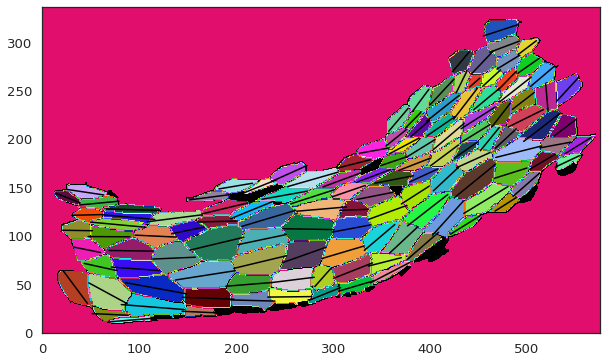

In [65]:
plt.figure(figsize=(10,10))
plt.imshow(seg,origin='lower',cmap=cmap_rand)
for i in range(len(Dataframe_geo)):
    startx = Dataframe_geo['x_0'][i] - Dataframe_geo['a'][i] * np.cos(Dataframe_geo['theta'][i])
    starty = Dataframe_geo['y_0'][i] - Dataframe_geo['a'][i] * np.sin(Dataframe_geo['theta'][i])
    endx = Dataframe_geo['x_0'][i] + Dataframe_geo['a'][i] * np.cos(Dataframe_geo['theta'][i])
    endy = Dataframe_geo['y_0'][i] + Dataframe_geo['a'][i] * np.sin(Dataframe_geo['theta'][i])
    
    
    plt.plot([startx, endx], [starty, endy], color='black')

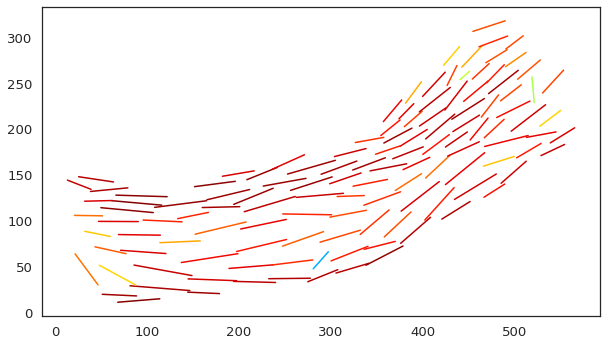

In [66]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
#plt.imshow(seg,origin='lower',cmap=cmap_rand)
for i in range(len(Dataframe_geo)):
    startx = Dataframe_geo['x_0'][i] - Dataframe_geo['a'][i] * np.cos(Dataframe_geo['theta'][i])
    starty = Dataframe_geo['y_0'][i] - Dataframe_geo['a'][i] * np.sin(Dataframe_geo['theta'][i])
    endx = Dataframe_geo['x_0'][i] + Dataframe_geo['a'][i] * np.cos(Dataframe_geo['theta'][i])
    endy = Dataframe_geo['y_0'][i] + Dataframe_geo['a'][i] * np.sin(Dataframe_geo['theta'][i])

    colori = plt.cm.jet(Dataframe_geo['e'][i]) # r is 0 to 1 inclusive
        
    plt.plot([startx, endx], [starty, endy], color=colori)
   
#plt.colorbar(Dataframe_geo_bis['e'])

In [67]:
from matplotlib.collections import LineCollection

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

In [68]:
'''Fonction pour la jolie color bar'''

from mpl_toolkits import axes_grid1

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

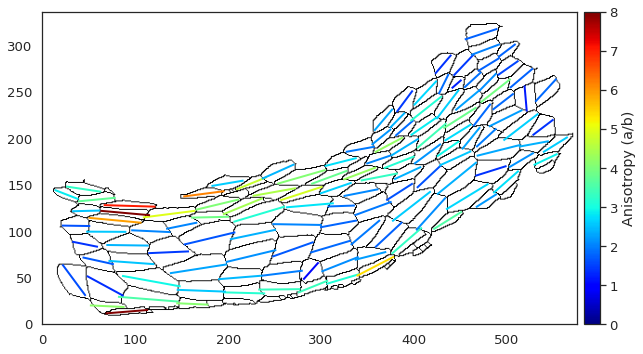

In [69]:
fig = plt.figure(figsize=(10,9))
ax.set_aspect('equal')
#plt.imshow(seg,origin='lower',cmap='viridis')
plt.imshow(InvMaskFil,origin='lower',cmap='gist_gray')
xs = []
ys = []
for i in range(len(Dataframe_geo)):
    startx = Dataframe_geo['x_0'][i] - Dataframe_geo['a'][i] * np.cos(Dataframe_geo['theta'][i])
    starty = Dataframe_geo['y_0'][i] - Dataframe_geo['a'][i] * np.sin(Dataframe_geo['theta'][i])
    endx = Dataframe_geo['x_0'][i] + Dataframe_geo['a'][i] * np.cos(Dataframe_geo['theta'][i])
    endy = Dataframe_geo['y_0'][i] + Dataframe_geo['a'][i] * np.sin(Dataframe_geo['theta'][i])
    
    xs.append([startx,endx])
    ys.append([starty,endy])
c = Dataframe_geo['an']
lc = multiline(xs, ys, c, cmap='jet', lw=2, clim = (0,8))
add_colorbar(lc, aspect=0.05, pad_fraction=0.5, label = 'Anisotropy (a/b)')

In [70]:
%matplotlib notebook

<IPython.core.display.Javascript object>


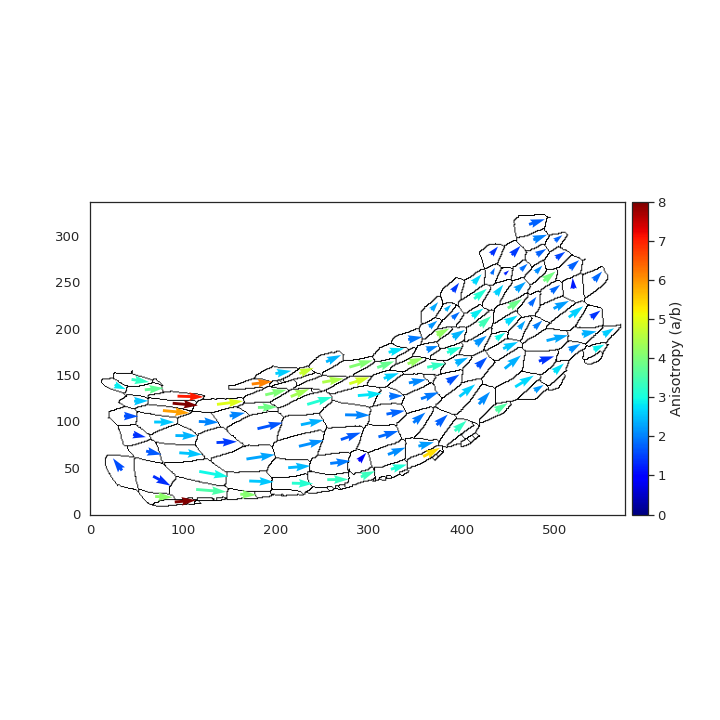

In [71]:
cmap1 = plt.cm.jet(np.arange(256))
cmap1[0] = [1., 1., 1., 1.]
cmap1 = ListedColormap(cmap1, name='myColorM', N=cmap1.shape[0])



fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(InvMaskFil,origin='lower',cmap='gist_gray')
q = ax.quiver(Dataframe_geo['x_0'], Dataframe_geo['y_0'], 
              0.5*Dataframe_geo['a'] * np.cos(Dataframe_geo['theta']), 
              0.5*Dataframe_geo['b'] * np.sin(Dataframe_geo['theta']), 
              Dataframe_geo['a']/Dataframe_geo['b'],
              units='xy' ,scale=0.5, 
              angles = Dataframe_geo['theta'] * 180 / np.pi,
              cmap='jet',
              clim = (0,8)
                                                    )
ax.set_aspect('equal')
#lc = multiline(xs, ys, c, cmap='jet', lw=2)
#axcb = fig.colorbar(lc)at's why it's called a la Turk.

add_colorbar(q, aspect=0.05, pad_fraction=0.5, label = 'Anisotropy (a/b)')


<IPython.core.display.Javascript object>


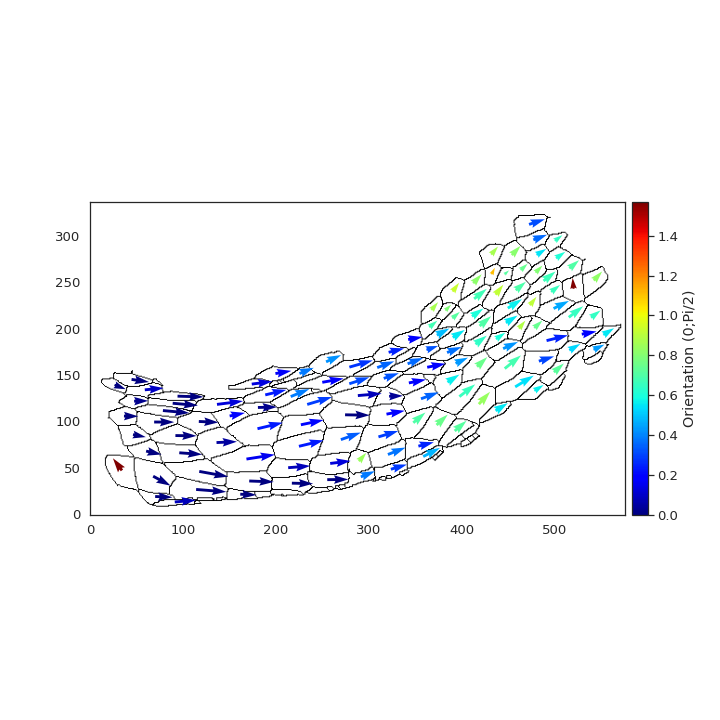

In [77]:
#Longueur de la flêche -> demi grand axe
#Couleur de la flêche -> Orientation (theta)


fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(InvMaskFil,origin='lower',cmap='gist_gray')
q = ax.quiver(Dataframe_geo['x_0'], Dataframe_geo['y_0'], 
              0.5*Dataframe_geo['a'] * np.cos(Dataframe_geo['theta']), 
              0.5*Dataframe_geo['b'] * np.sin(Dataframe_geo['theta']), 
              Dataframe_geo['theta'],
              units='xy' ,scale=0.5, 
              angles = Dataframe_geo['theta'] * 180 / np.pi,
              cmap='jet',
              clim = (0,np.pi/2)
                                                    )
ax.set_aspect('equal')
#lc = multiline(xs, ys, c, cmap='jet', lw=2)
#axcb = fig.colorbar(lc)at's why it's called a la Turk.

add_colorbar(q, aspect=0.05, pad_fraction=0.5, label = 'Orientation (0;Pi/2)')


In [1]:
print('blabla')


blabla
